In [1]:
import cogsworth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u

In [2]:
# this all just makes plots look nice
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)
pd.options.display.max_columns = 999

In [3]:
p = cogsworth.pop.Population(100, final_kstar1=[14], timestep_size=0.1 * u.Myr,
                             use_default_BSE_settings=True)
p.galactic_potential

<CompositePotential disk,bulge,nucleus,halo>

In [4]:
p.galactic_potential["disk"]

<MiyamotoNagaiPotential: m=6.80e+10, a=3.00, b=0.28 (kpc,Myr,solMass,rad)>

In [5]:
p.galactic_potential.circular_velocity(q=[8.5, 0, 0] * u.kpc)

<Quantity [230.74831669] km / s>

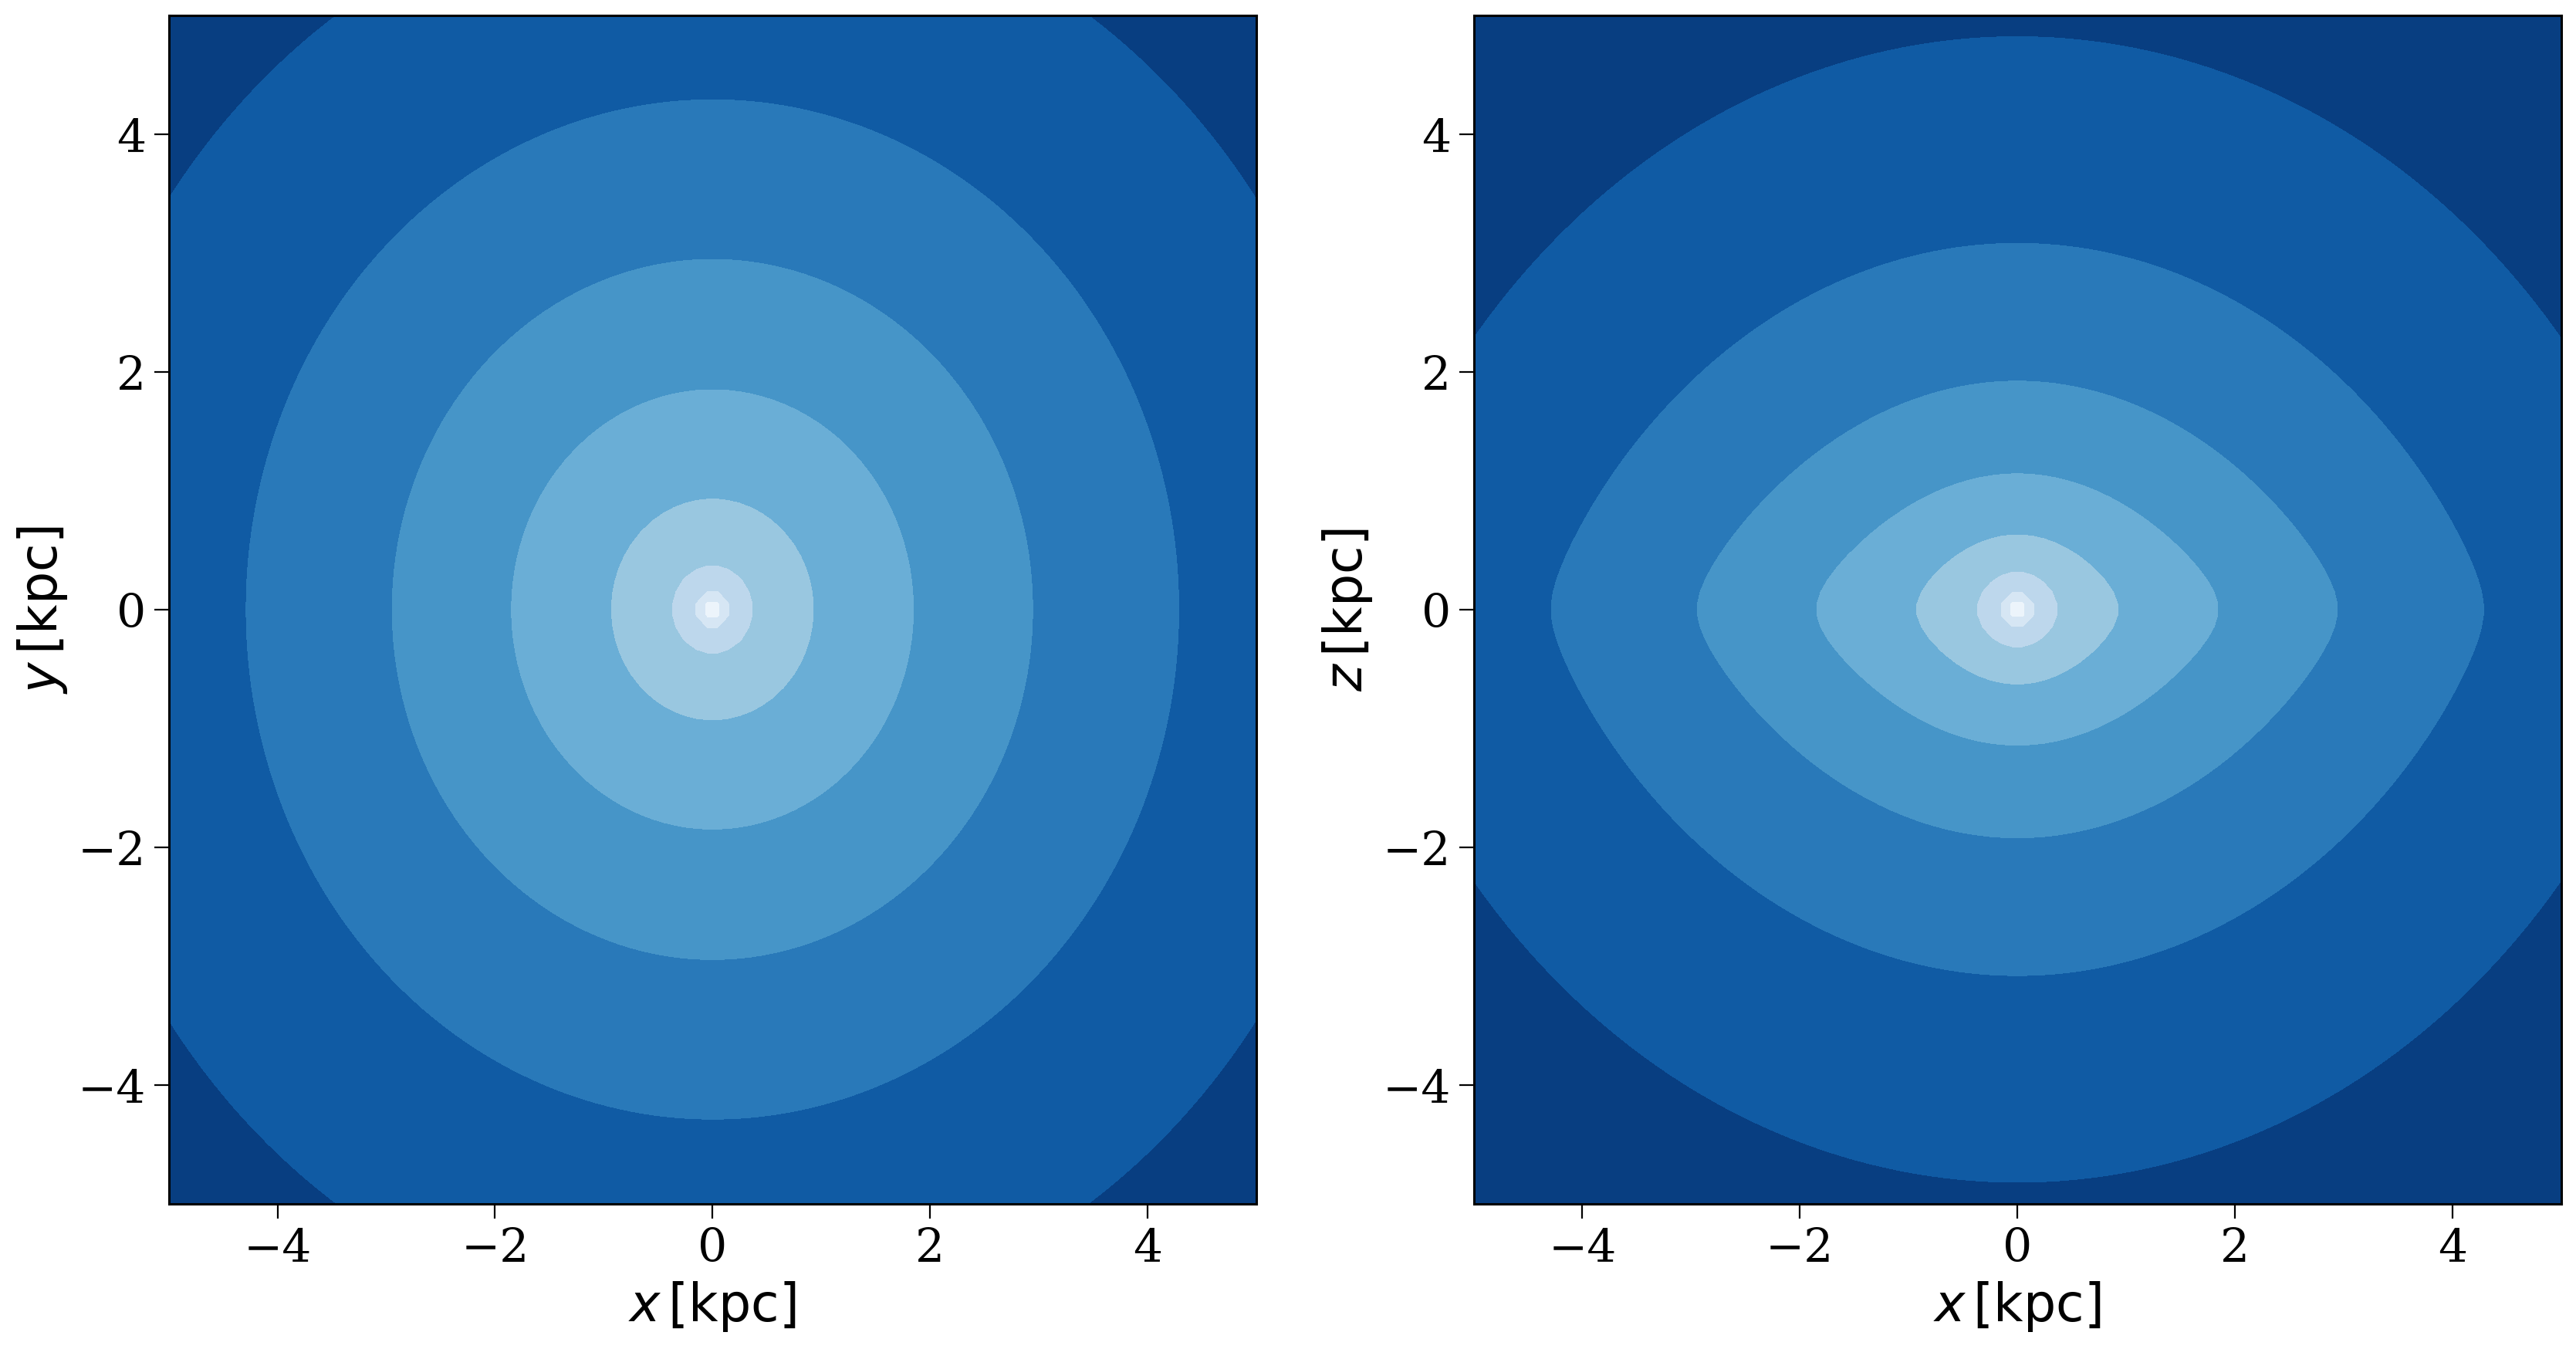

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# define a basic grid to use
grid = np.linspace(-5, 5, 100) * u.kpc

# plot using the grid for x, y, but fixing z=0 kpc (repeat for x-z with y=0)
p.galactic_potential.plot_contours(grid=(grid, grid, 0), ax=axes[0]);
p.galactic_potential.plot_contours(grid=(grid, 0, grid), ax=axes[1]);

axes[0].set(xlabel=r'$x \, [\rm kpc]$', ylabel=r'$y \, [\rm kpc]$')
axes[1].set(xlabel=r'$x \, [\rm kpc]$', ylabel=r'$z \, [\rm kpc]$')

plt.show()

In [7]:
np.random.seed(27)
p.create_population(with_timing=False)
p.orbits[0]

<Orbit cartesian, dim=3, shape=(86083,)>

In [8]:
p.orbits[0].pos, p.orbits[0].vel, p.orbits[0].t

(<CartesianRepresentation (x, y, z) in kpc
     [( 6.04939119,   1.21670957,  2.05043662),
      ( 6.04452751,   1.23916624,  2.05139465),
      ( 6.03959326,   1.26160844,  2.05231088), ...,
      (10.12471541, -22.65519926, -8.0476781 ),
      (10.13381147, -22.65817734, -8.0508967 ),
      (10.14290089, -22.66114055, -8.05410955)]>,
 <CartesianDifferential (d_x, d_y, d_z) in kpc / Myr
     [(-0.04828374,  0.22463818,  0.0097893 ),
      (-0.04898975,  0.22449481,  0.00937133),
      (-0.04969513,  0.22434883,  0.00895329), ...,
      ( 0.09099389, -0.02985514, -0.03221465),
      ( 0.0909274 , -0.02970641, -0.03215724),
      ( 0.09086088, -0.02955775, -0.03209984)]>,
 <Quantity [ 3391.71858439,  3391.81858439,  3391.91858439, ...,
            11999.71858439, 11999.81858439, 11999.91858439] Myr>)

In [9]:
p.orbits[0].z

<Quantity [ 2.05043662,  2.05139465,  2.05231088, ..., -8.0476781 ,
           -8.0508967 , -8.05410955] kpc>

In [10]:
p.orbits[0].cylindrical.rho

<Quantity [ 6.17053611,  6.17023871,  6.16995483, ..., 24.81467138,
           24.82110262, 24.82751959] kpc>

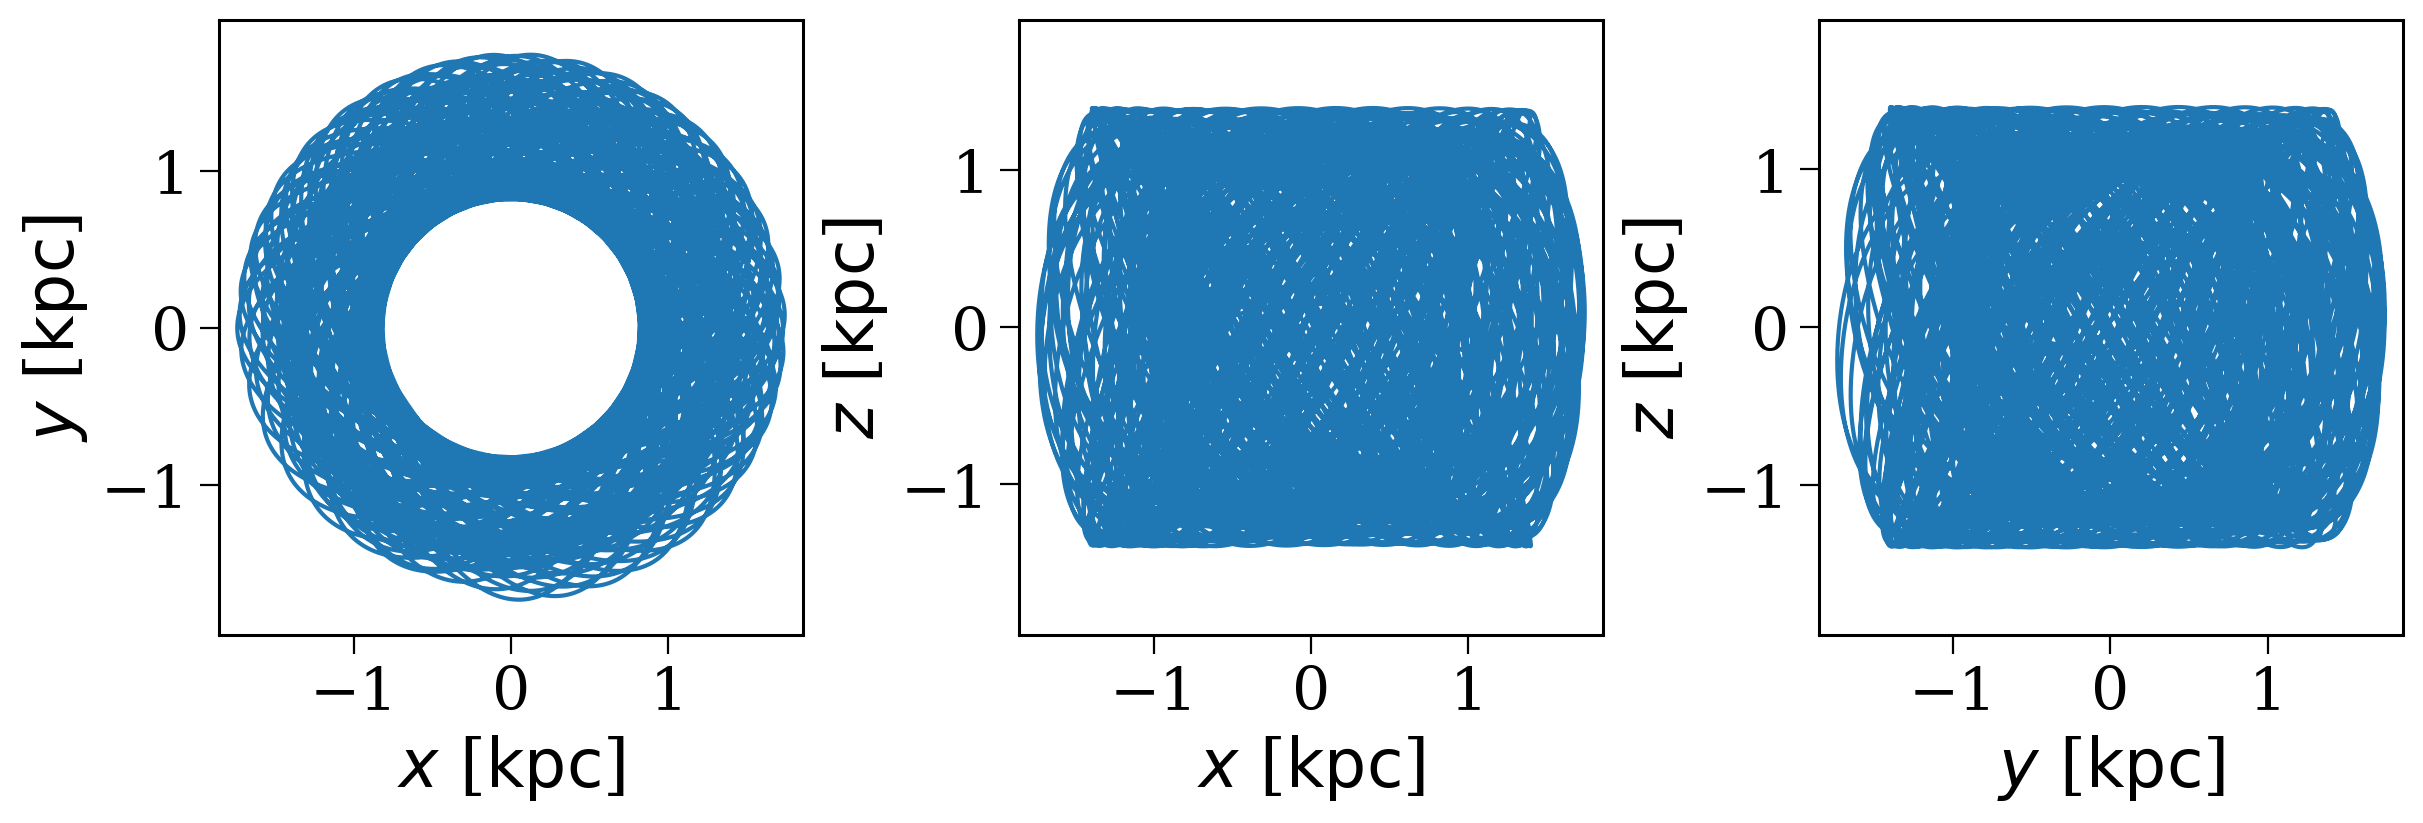

In [11]:
plot_orbit = p.primary_orbits[~p.disrupted & ~p.escaped[:len(p)]][0]
plot_orbit.plot();

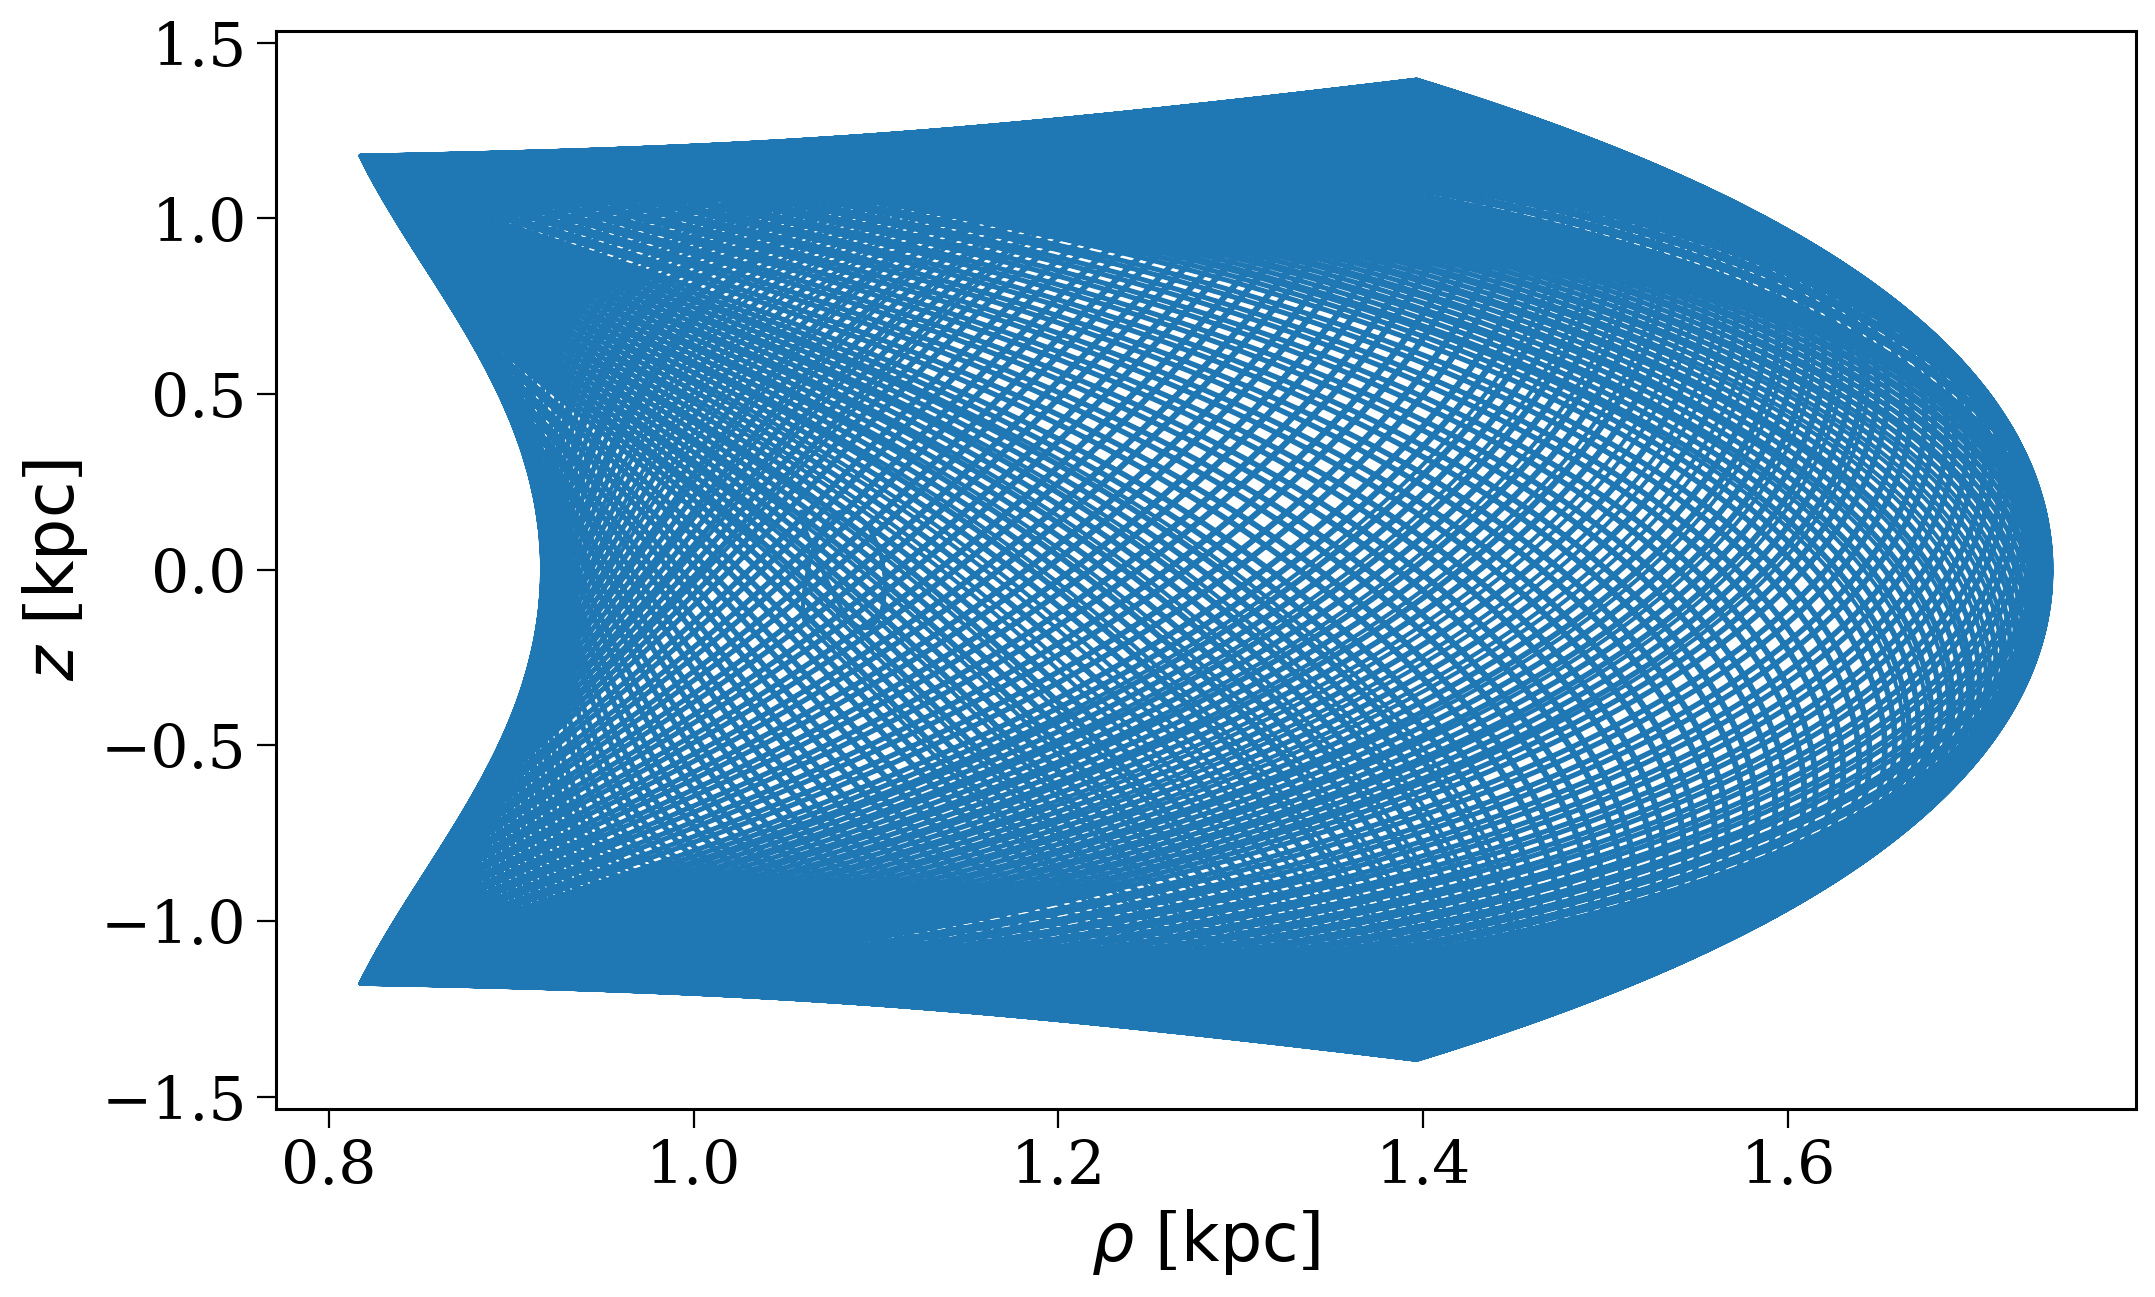

In [12]:
fig, ax = plt.subplots(figsize=(12, 7))
plot_orbit.cylindrical.plot(['rho', 'z'], axes=[ax]);

In [13]:
orbit_options_mask = p.disrupted & ~p.escaped[:len(p)]
orbit_options_bin_nums = p.bin_nums[orbit_options_mask]

In [14]:
primary_orbit_options = p.primary_orbits[orbit_options_mask]
secondary_orbit_options = p.secondary_orbits[orbit_options_mask]
target_orbit = None
for i in range(len(primary_orbit_options)):
    if ((primary_orbit_options[i].z.max() > 1 * u.kpc)
        & (primary_orbit_options[i].z.max() < 10 * u.kpc)
        & (secondary_orbit_options[i].z.max() > 1 * u.kpc)
        & (secondary_orbit_options[i].z.max() < 10 * u.kpc)):
        target_ind = i
        break

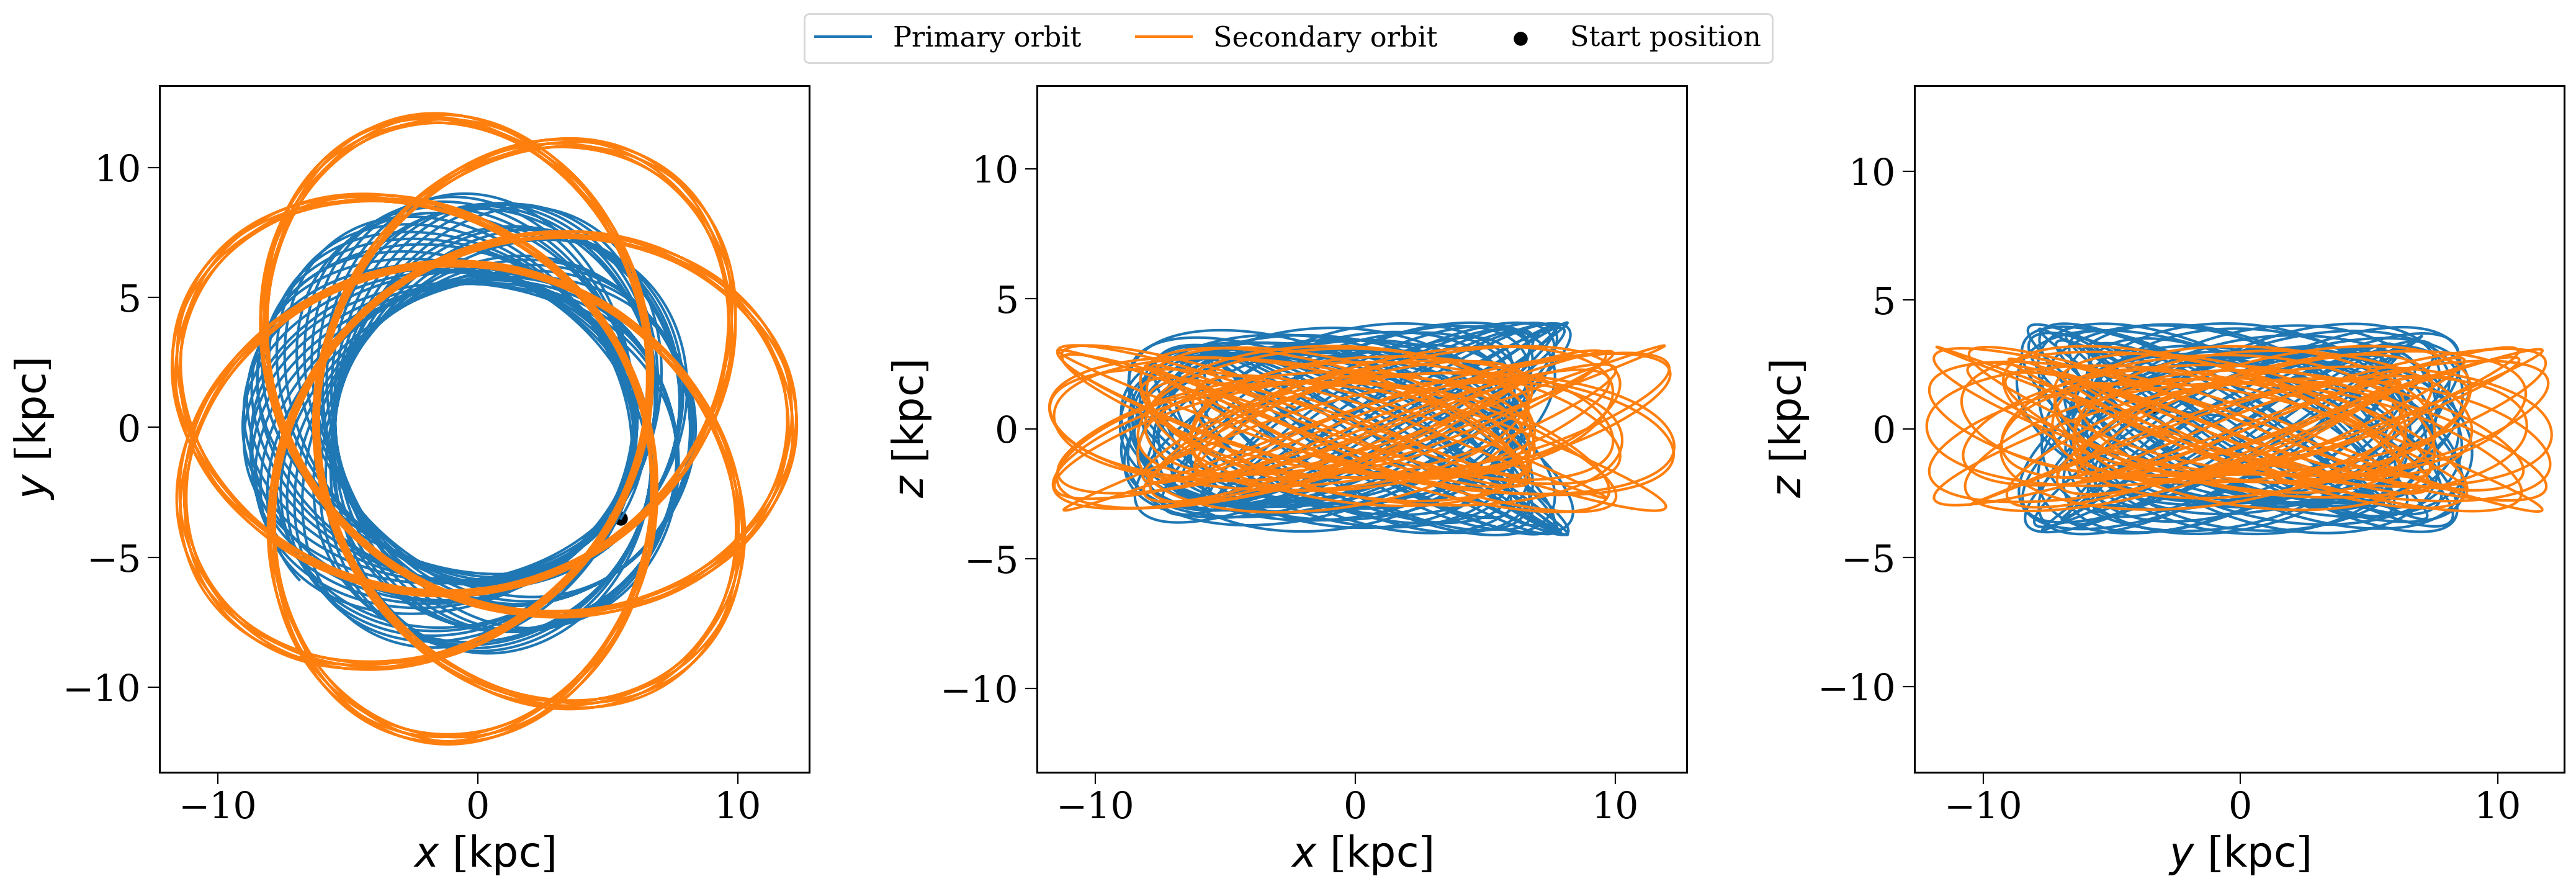

In [15]:
p.plot_orbit(orbit_options_bin_nums[target_ind], show_sn=False);

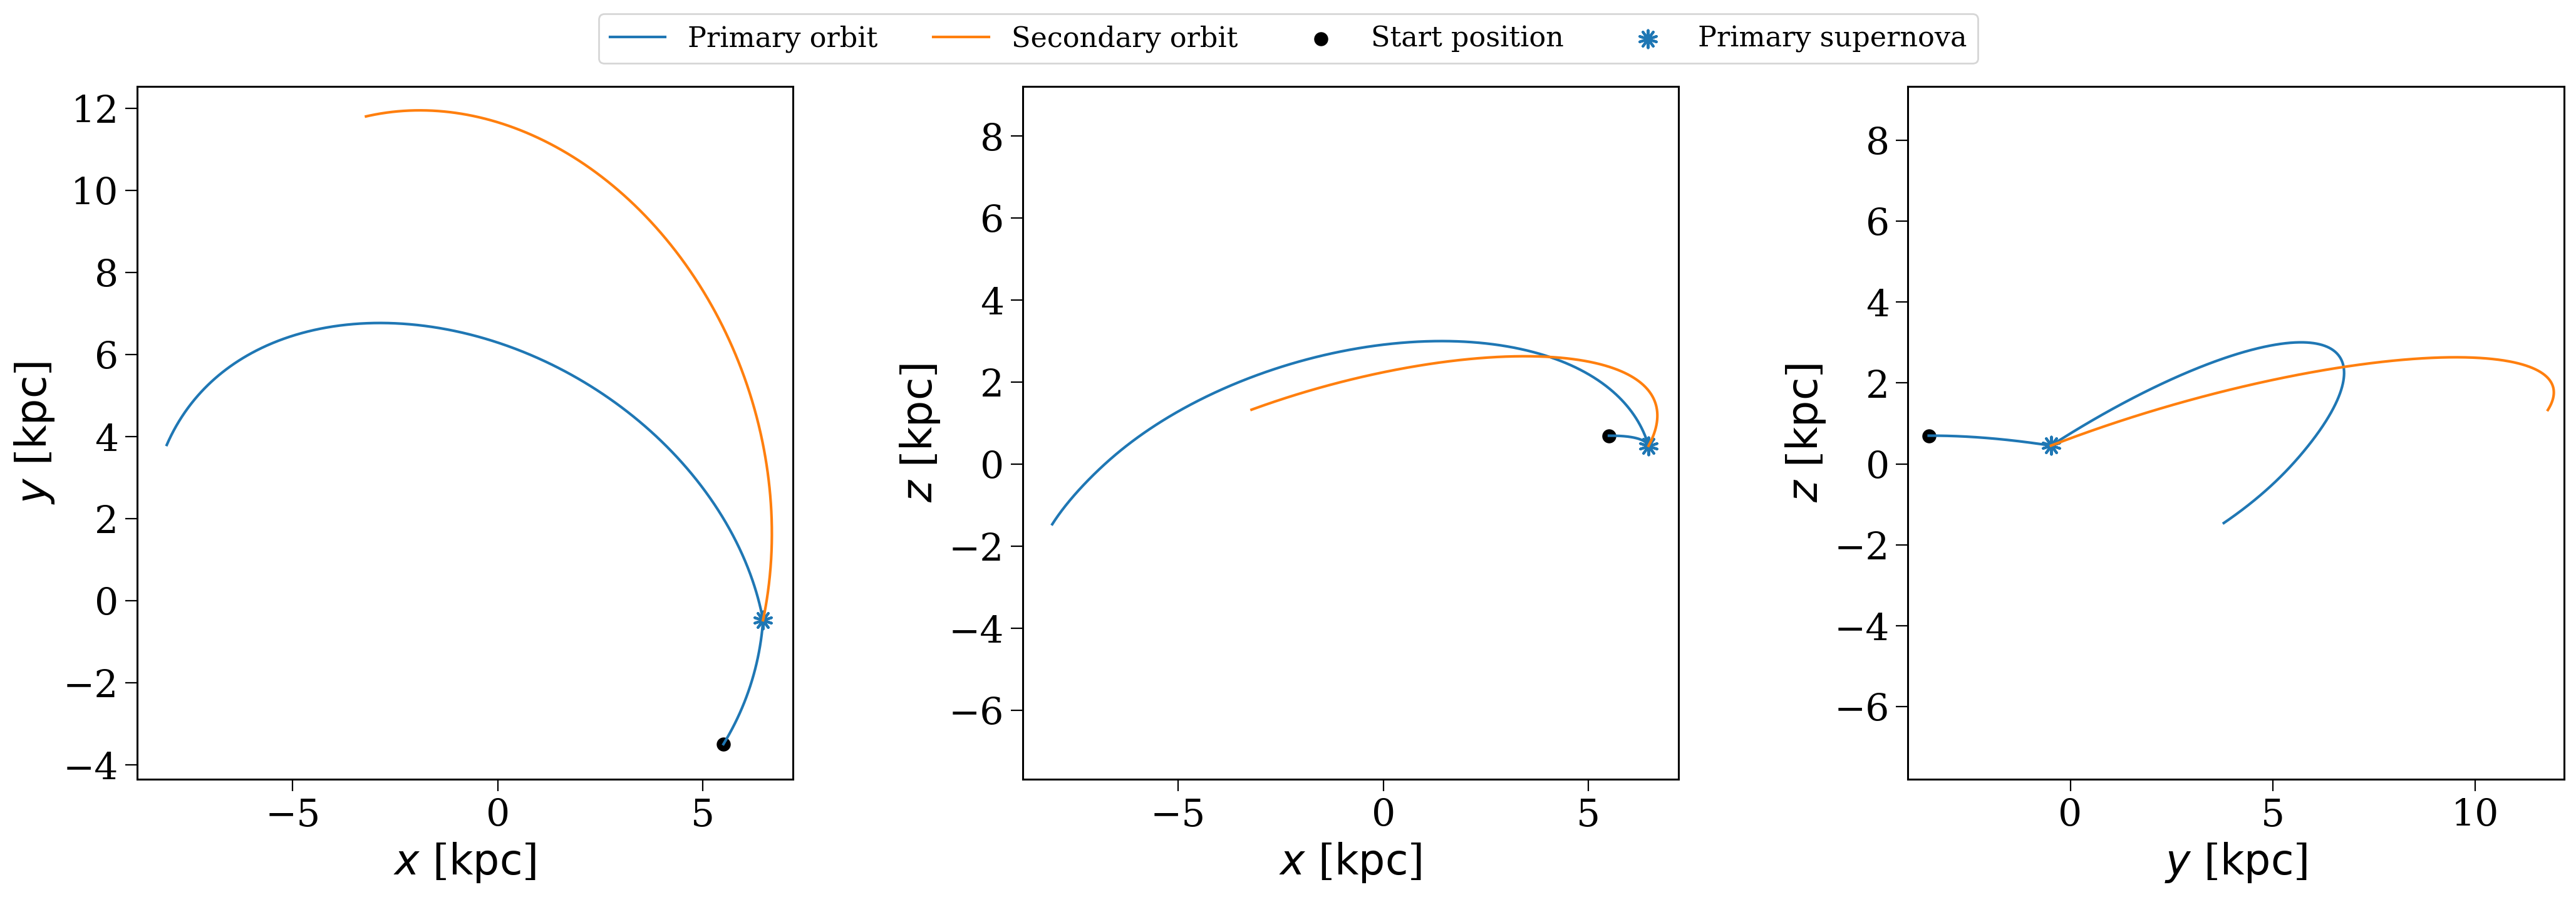

In [16]:
p.plot_orbit(orbit_options_bin_nums[target_ind], show_sn=True, t_max=100 * u.Myr);